In [29]:
import numpy as np
# 訓練データと検証データの分割
from sklearn.model_selection import train_test_split
# 予測結果の精度確認（ROC曲線の描画）
from sklearn.metrics import roc_auc_score, roc_curve
# データを扱う
import pandas as pd
# グラフ描画
from matplotlib import pyplot as plt

In [2]:
import torch
# 自動微分の関数 
from torch.autograd import Variable
# ニューラルネットワークの関数
import torch.nn as nn
# 活性化関数
import torch.nn.functional as F
# 最適化のアルゴリズムの関数
import torch.optim as optim
#ユーティリティのデータから
from torch.utils.data import DataLoader ,TensorDataset

## 訓練データの読み込み

In [3]:
# CSVファイル読み込み（訓練データ）
df_train = pd.read_csv('train.csv')
df_train.head()

,Age,Gender,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,TP,Alb,AG_ratio,disease
0,59,Male,0.786886,0.150498,220.178691,13.467617,21.729246,6.815731,3.112276,1.006802,0
1,69,Male,1.003987,0.195625,221.218413,51.033462,64.752323,6.889608,3.051521,0.751346,1
2,65,Male,0.657140,0.081287,320.770533,12.625011,30.613180,5.947767,2.489167,0.774952,0
3,65,Male,0.906822,0.214173,369.278160,34.347597,54.510085,6.967183,3.613837,0.988155,1
4,22,Female,1.734959,0.197706,222.782025,20.572891,170.010177,5.837537,3.068697,1.026654,0


In [4]:
#　性別と結果は数値でないため、除外する（分析用）
col_categoric = ["Gender", "disease"]
df_numeric = df_train.drop(col_categoric, axis=1)
df_categoric = df_train[col_categoric]

In [5]:
# 性別を変換する（訓練データ）
df_train["Gender"] = df_train["Gender"].apply(lambda x: 1 if x=="Male" else 0)
df_train.head()

,Age,Gender,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,TP,Alb,AG_ratio,disease
0,59,1,0.786886,0.150498,220.178691,13.467617,21.729246,6.815731,3.112276,1.006802,0
1,69,1,1.003987,0.195625,221.218413,51.033462,64.752323,6.889608,3.051521,0.751346,1
2,65,1,0.657140,0.081287,320.770533,12.625011,30.613180,5.947767,2.489167,0.774952,0
3,65,1,0.906822,0.214173,369.278160,34.347597,54.510085,6.967183,3.613837,0.988155,1
4,22,0,1.734959,0.197706,222.782025,20.572891,170.010177,5.837537,3.068697,1.026654,0


In [6]:
df_train.describe()

,Age,Gender,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,TP,Alb,AG_ratio,disease
count,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000
mean,46.610588,0.825882,1.607337,0.606737,272.211316,41.978476,61.018120,7.032290,3.517458,1.144570,0.444706
std,16.453672,0.379434,2.443585,1.569032,200.348515,145.927366,110.125390,0.840664,0.559942,0.227237,0.497226
min,10.000000,0.000000,0.585961,0.034861,163.261838,3.924518,11.283497,4.858679,2.180884,0.627133,0.000000
25%,32.000000,1.000000,0.781258,0.144889,213.991414,13.644658,21.239157,6.730612,3.139153,1.004466,0.000000
50%,48.000000,1.000000,0.835591,0.194085,220.092503,16.638001,27.056026,6.915580,3.621339,1.205016,0.000000
75%,62.000000,1.000000,1.196759,0.335447,229.455927,23.056081,56.461568,7.536151,3.712524,1.287880,1.000000
max,78.000000,1.000000,23.017027,17.692164,2108.483728,1423.186473,814.439397,8.739000,5.016970,1.821496,1.000000


# 評価データの読み込み

In [7]:
# CSVファイル読み込み（評価データ）
df_vat = pd.read_csv('test.csv')
df_vat.head()

,Age,Gender,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,TP,Alb,AG_ratio
0,25,Male,0.801797,0.186800,214.448679,15.260516,19.496649,6.817903,3.600752,1.288006
1,26,Female,0.834857,0.116426,234.136816,10.509159,16.733312,6.795433,3.111043,1.030562
2,64,Male,0.791830,0.197940,216.039909,14.578304,20.695866,7.524030,3.627621,1.278579
3,65,Male,0.834003,0.175741,200.901130,12.820356,20.102517,6.829109,3.626758,1.275070
4,34,Female,0.690296,0.135503,208.705835,20.279018,25.096685,8.663530,4.170750,1.280078


In [8]:
# 性別を変換する（検証データ）
df_vat["Gender"] = df_vat["Gender"].apply(lambda x: 1 if x=="Male" else 0)
df_vat.head()

,Age,Gender,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,TP,Alb,AG_ratio
0,25,1,0.801797,0.186800,214.448679,15.260516,19.496649,6.817903,3.600752,1.288006
1,26,0,0.834857,0.116426,234.136816,10.509159,16.733312,6.795433,3.111043,1.030562
2,64,1,0.791830,0.197940,216.039909,14.578304,20.695866,7.524030,3.627621,1.278579
3,65,1,0.834003,0.175741,200.901130,12.820356,20.102517,6.829109,3.626758,1.275070
4,34,0,0.690296,0.135503,208.705835,20.279018,25.096685,8.663530,4.170750,1.280078


## データを加工する

In [9]:
def xConv(x_tmp):
    # T_Bil、D_Bilの変換
    bins1 = [0, 0.6,  0.7, 0.75, 0.8, 0.9, 1.0, 1.2, 1.3, 1.4, 1.5, 1.8, 100]
    bins2 = [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.8, 100]
    x_tmp=comCutCnnect(x_tmp, bins1, 'T_Bil' , bins2, 'D_Bil' )
    
    # T_Bil、D_Bilの変換
    bins1 = [0, 5, 7.5, 10, 12.5, 15, 17.5, 20, 22.5, 25, 50, 100, 125,1500]
    bins2 = [0, 20, 25,  30, 35,  40, 50, 60, 70, 80, 100, 140, 180,900]
    x_tmp=comCutCnnect(x_tmp, bins1, 'ALT_GPT' , bins2, 'AST_GOT' )
    
    return x_tmp


def comCutCnnect(x_tmp,bins1 ,col1, bins2 ,col2 ):   
    X_cut_1 = pd.cut(x_tmp[col1], bins=bins1, labels=False)
    X_cut_2 = pd.cut(x_tmp[col2], bins=bins2, labels=False)
    X_cut = pd.DataFrame(np.array(X_cut_1) * np.array(X_cut_2) , columns={col1})
    x_tmp.drop(columns=[col1 , col2], inplace=True, axis=1)
    x_tmp = pd.concat([x_tmp, X_cut], axis=1)
    return x_tmp

In [10]:
# 説明変数（訓練データ）
x_tmp=xConv(df_train.loc[:,['Age', 'Gender', 'T_Bil', 'D_Bil', 'ALP', 'ALT_GPT', 'AST_GOT', 'TP', 'Alb','AG_ratio']])
x_train = np.array(x_tmp)
print(x_tmp.head())
# 目的変数（訓練データ）
y_train = np.array(df_train.loc[:,['disease']])


# 説明変数（評価データ）
x_tmp=xConv(df_vat)
x_vat = np.array(x_tmp)
print(x_tmp.head())

   Age  Gender         ALP        TP       Alb  AG_ratio  T_Bil  ALT_GPT
0   59       1  220.178691  6.815731  3.112276  1.006802      9        4
1   69       1  221.218413  6.889608  3.051521  0.751346     18       70
2   65       1  320.770533  5.947767  2.489167  0.774952      1       12
3   65       1  369.278160  6.967183  3.613837  0.988155     20       54
4   22       0  222.782025  5.837537  3.068697  1.026654     30       77
   Age  Gender         ALP        TP       Alb  AG_ratio  T_Bil  ALT_GPT
0   25       1  214.448679  6.817903  3.600752  1.288006     12        0
1   26       0  234.136816  6.795433  3.111043  1.030562      8        0
2   64       1  216.039909  7.524030  3.627621  1.278579      9        4
3   65       1  200.901130  6.829109  3.626758  1.275070     12        4
4   34       0  208.705835  8.663530  4.170750  1.280078      2       14


In [11]:
y = np.zeros((len(y_train), 1 + y_train.max()), dtype=int)
y[np.arange(len(y_train)), y_train.T] = 1
y_train = y
X_train,X_test,Y_train,Y_test=train_test_split(x_train, y_train, test_size=0.25, random_state=1) 

In [12]:
# numpy の値を torch の値に変換する
X_train = torch.from_numpy(X_train).float()
Y_train = torch.from_numpy(Y_train).float()
X_test = torch.from_numpy(X_test).float()
Y_test = torch.from_numpy(Y_test).float()
X_vat  = torch.from_numpy(x_vat).float()

In [13]:
# 行数、列数の確認
in_size=X_train.shape[1]
print(X_train.shape)
print(X_test.shape)


torch.Size([637, 8])
torch.Size([213, 8])


In [14]:
out_size=Y_train.shape[1]
Y_train.shape

torch.Size([637, 2])

In [15]:
print(X_vat.shape)


torch.Size([350, 8])


In [16]:
# x と y の値をひとつの変数に格納する
train = TensorDataset(X_train ,Y_train)

In [17]:
# batch_size ：学習する時にまとめるデータ数
# shuffle    : データをランダムに並び替える場合はTrue
train_loader = DataLoader(train ,batch_size=15, shuffle=True)

In [18]:
node1=40
node2=15
node3=8


# Module を継承して、Netクラスを作成する
#  ノード数や階層を増やす　⇒　精度が向上する、学習のパフォーマンスは落ちる
#  ノード数や階層を減らす　⇒　精度が下がる、学習のパフォーマンスは上がる
#   　ノードや階層を変更しても精度が上がらない　⇒　入力データが不足している
class Net(nn.Module):
    # 初期化の関数
    def __init__(self):
        super(Net ,self).__init__()
        #   中間層のノード数は、精度向上やパフォーマンス向上を狙って調整する
        self.fc1 = nn.Linear(in_size , node1)         # nn.Linear (入力のノード数 , 中間層ノード数)
        self.fc2 = nn.Linear(node1 , node2)           # nn.Linear (中間層ノード数 , 中間層ノード数)
        self.fc3 = nn.Linear(node2 , node3)           # nn.Linear (中間層ノード数 , 中間層ノード数)
        self.fc4 = nn.Linear(node3,  out_size)        # nn.Linear (中間層ノード数 , 出力のノード数)
    
    # ネットワークを通して、出力値を求める関数
    def forward(self ,x):
#        x = F.relu(self.fc1(x))              # 入力のノードを中間層（１階層目）に渡して結果を得る
#        x = F.sigmoid(self.fc2(x))              # 中間層（１階層目）を中間層（２階層目）に渡して結果を得る
        x = F.relu(self.fc1(x))              # 入力のノードを中間層（１階層目）に渡して結果を得る
        x = F.relu(self.fc2(x))              # 中間層（１階層目）を中間層（２階層目）に渡して結果を得る
        x = F.relu(self.fc3(x))              # 中間層（１階層目）を中間層（２階層目）に渡して結果を得る
        x = self.fc4(x)                         # 中間層（２階層目）の結果を出力層に渡す
        # dim　:求めたい確率の値　今回は１になる確率
        return F.log_softmax(x , dim=0)
        #return F.softmax(x , dim=0)

In [19]:
# モデルの定義
model = Net()
# 損失の定義 (平均二乗誤差)
criterion = nn.MSELoss()
# 損失の定義 (交差エントロピー誤差関数)
#criterion = nn.CrossEntropyLoss()

In [20]:
# 最適化のアルゴリズムの選択　（Adam：Stochastic Gradient Descent）
## model.parameters  調整する値
## lr(learning rate) ：学習率　どれぐらいの幅でパラメータを更新していくのか
optimizer = optim.Adam(model.parameters() , lr=0.001)
#optimizer = optim.SGD(model.parameters() , lr=0.001)

In [21]:
loss_list = []
loss_temp = 0
logdisp=10
# トレーニングの回数分ループする。
for epoch in range(200):
    # 損失を初期化　
    total_loss = 0
    
    # データの件数分ループする。（x_train , y_train　に１レコードずつ格納される）
    for x_train , y_train in train_loader:
        # Variable ：　torch,autograd.Variable  ：テンソルをwrapして計算操作を記録する
        x_train ,y_train = Variable(x_train) ,Variable(y_train)
        # 出力を計算する 
        output = model(x_train)
        # 損失の計算 (出力の結果；output と 正解：y_trainを渡す)
        loss = criterion(output ,y_train)
        # パラメータの勾配を初期化する
        optimizer.zero_grad()
        # ロスを伝播する
        loss.backward()
        # パラメータを更新する
        optimizer.step()
        # トータルロスを格納
        total_loss += loss.item()
        loss_temp += loss

    # 10回毎に回数とトータルロスを表示する
    if (epoch+1)%logdisp == 0:
        loss_list.append(loss.item()/(logdisp*len(train_loader)))
        print(f'Epoch {epoch+1} Loss {loss.item()/(logdisp*len(train_loader))} -- {loss_temp}')
        loss_temp = 0

Epoch 10 Loss 0.01449216132940248 -- 5138.33544921875
Epoch 20 Loss 0.014445353663244913 -- 4484.4052734375
Epoch 30 Loss 0.014474842160247093 -- 4481.2646484375
Epoch 40 Loss 0.014410464708195176 -- 4480.22265625
Epoch 50 Loss 0.01436343414838924 -- 4479.8515625
Epoch 60 Loss 0.01438783933950025 -- 4479.619140625
Epoch 70 Loss 0.014383680875911268 -- 4479.4365234375
Epoch 80 Loss 0.014446829640588094 -- 4479.69287109375
Epoch 90 Loss 0.01444847861001658 -- 4478.86474609375
Epoch 100 Loss 0.014508068838784862 -- 4479.0107421875
Epoch 110 Loss 0.014355805862781613 -- 4478.56982421875
Epoch 120 Loss 0.01441228888755621 -- 4488.2802734375
Epoch 130 Loss 0.014348158725472383 -- 4478.55517578125
Epoch 140 Loss 0.014436803862105968 -- 4478.43212890625
Epoch 150 Loss 0.014427076384078625 -- 4477.9267578125
Epoch 160 Loss 0.01436754160149153 -- 4477.6220703125
Epoch 170 Loss 0.014451130046400912 -- 4477.80322265625
Epoch 180 Loss 0.01445677446764569 -- 4477.8828125
Epoch 190 Loss 0.01438883958

findfont: Font family ['IPAexGothic'] not found. Falling back to DejaVu Sans.


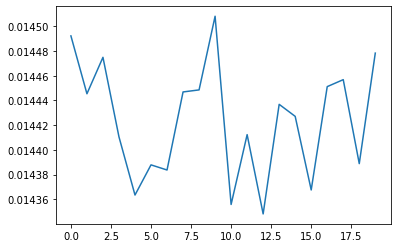

In [22]:
# ロスのプロット
plt.plot(loss_list)

## 誤差の確認

In [23]:
#print(Y_test)

In [24]:
# 学習を行わないモードに変更
model.eval()

# テストデータ
x ,y = Variable(X_test) ,Variable(Y_test)
# テストデータｘに対する結果　（値の大きい方を取得する）
y_hat = torch.max(model(x).data ,1)[1]
y_true = torch.max(y ,1)[1]
# テストｘの結果とｙの比較　（結果が一致したら加算して、不一致は加算しない。その結果をデータ数で割る）
accuracy = np.sum(y_true.data.numpy() == y_hat.numpy()) /len(y_true.data.numpy())
print(accuracy)
print(y_hat.numpy())
print(y_true.data.numpy())

0.8732394366197183
[0 1 0 1 1 1 0 1 1 0 1 1 1 0 0 0 1 1 1 0 0 1 0 0 1 0 1 0 1 0 1 0 1 0 0 0 1
 0 0 0 0 0 1 1 1 1 0 1 0 0 0 0 0 0 1 1 1 0 0 0 0 1 0 0 0 1 1 1 1 1 0 0 1 0
 1 0 1 1 1 0 0 0 0 0 1 0 1 0 0 0 0 1 0 0 0 0 0 1 1 0 1 0 0 0 1 1 0 0 0 0 0
 1 0 0 1 1 0 0 1 1 1 1 1 0 0 1 1 0 0 1 0 0 0 1 0 1 0 1 0 1 1 1 0 0 1 1 0 1
 1 0 1 1 0 1 1 1 0 0 0 0 1 1 0 0 0 1 1 0 0 1 0 1 0 0 1 1 0 0 0 1 1 0 1 0 1
 1 0 0 0 0 1 0 1 0 0 1 0 0 1 0 1 1 0 0 0 1 0 1 1 0 1 1 0]
[1 1 0 1 1 1 0 1 1 1 1 1 1 0 1 0 1 1 1 0 0 1 0 0 1 1 1 0 1 1 1 0 1 1 0 0 1
 0 0 0 1 0 0 1 1 1 0 1 0 0 0 0 0 0 1 1 1 0 0 0 0 1 1 0 0 1 1 1 1 1 0 0 1 0
 1 0 1 1 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 1
 1 0 0 1 1 0 0 1 0 1 1 1 0 0 1 1 1 0 1 0 0 0 1 0 1 0 1 0 1 1 1 0 0 1 1 0 1
 1 0 1 1 0 1 1 0 0 0 0 0 1 0 0 1 1 1 1 0 0 0 0 1 0 0 1 1 0 0 0 1 1 0 1 0 1
 1 0 0 0 0 0 0 1 0 0 1 0 1 1 0 1 1 0 0 0 1 0 0 1 0 1 0 0]


## ROC曲線の描画（偽陽性率、真陽性率、閾値の算出）

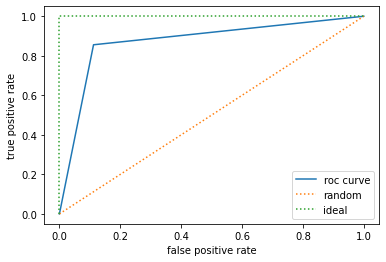

[2 1 0]


In [30]:
# ROC曲線の描画（偽陽性率、真陽性率、閾値の算出）
fpr, tpr, thresholds = roc_curve(y_true=y_true, y_score=y_hat)
plt.plot(fpr, tpr, label='roc curve')
plt.plot([0, 1], [0, 1], linestyle=':', label='random')
plt.plot([0, 0, 1], [0, 1, 1], linestyle=':', label='ideal')
plt.legend()
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.show()
print(thresholds)

In [32]:
# AUCスコアの算出
auc_score = roc_auc_score(y_true=y_true, y_score=y_hat)
print("AUC:", auc_score)

AUC: 0.8718005687877711


#  予測する

In [25]:
y_predict = torch.max(model(X_vat).data ,1)[1]
df_out = pd.DataFrame(np.array(y_predict.detach().numpy().copy(),dtype=np.int64), columns=['val'])
print(df_out)
df_out.to_csv('./submit.csv', encoding='utf_8_sig' , header=False)


     val
0      0
1      0
2      0
3      0
4      0
..   ...
345    0
346    0
347    0
348    0
349    1

[350 rows x 1 columns]


# モデルの保存

In [26]:
#model_path = 'model.pth'
#torch.save(model.to('cpu').state_dict(), model_path)